In [2]:
import numpy as np
import sys, os, glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

code_path = '/Users/GA/Documents/Dayan_lab/Optimism_And_Pessimism_In_Optimised_Replay/Code/Task'

sys.path.append(code_path)
from misc_analysis import get_Q_true, get_optimal_move, permutation_test, policy_improve, get_entropy, get_sorted_files
from misc import policy_choose, get_a_opp, compute_gain

In [3]:
root_folder = '/Users/GA/Documents/Dayan_lab/Optimism_And_Pessimism_In_Optimised_Replay'

# Worlds & idcs
world1 = np.load(os.path.join(root_folder, 'Data/world1.npy'))
world2 = np.load(os.path.join(root_folder, 'Data/world2.npy'))
idcs1  = np.load(os.path.join(root_folder, 'Data/idcs1.npy'))
idcs2  = np.load(os.path.join(root_folder, 'Data/idcs2.npy'))

In [4]:
def convert_move(a):
    if np.isnan(a):
        pass
    elif a == 1:
        a = 2
    elif a == 2:
        a = 3
    elif a == 3:
        a = 0
    else:
        a = 1
    return a

def check_for_replays(z):

    move = z['move']
    s = move[0]
    a = move[1]
    
    check = False
    
    replay_backups  = np.atleast_2d(z['replay_backups'])
    for rid in range(replay_backups.shape[0]):
        this_replay = replay_backups[rid, :]
        sr = int(this_replay[0])
        ar = int(this_replay[1])

        if sr != -200 and ar != -200:
            if (sr == s) and (ar == a):
                check = True
    return check

def check_for_replays_2moves(z):
    
    move = z['move']
    s = move[1, 0]
    a = move[1, 1]
    
    check = False
    
    replay_backups  = np.atleast_2d(z['replay_backups'])
    for rid in range(replay_backups.shape[0]):
        this_replay = replay_backups[rid, :]
        sr = int(this_replay[0])
        ar = int(this_replay[1])

        pl = int(this_replay[4])
        if sr != -200 and ar != -200 and pl == 1:
            if (sr == s) and (ar == a):
                check = True
    return check

### Check subjects' params before choosing

In [5]:
params_path     = os.path.join(root_folder, 'Data/fits')
subs_who_replay = np.load(os.path.join(root_folder, 'Data/task/Analysis', 'subs_who_replay.npy'))

In [6]:
for i in subs_who_replay:
    p = np.load(os.path.join(params_path, 'save_params_%u'%i, 'params.npy'))[:18]
    print('subject: %u, phi^{MB}: %.2f, phi^{MF}: %.2f, xi: %.4E'%(i, p[8], p[9], p[15]))

subject: 0, phi^{MB}: 0.98, phi^{MF}: 0.97, xi: 2.4568E-04
subject: 2, phi^{MB}: 1.00, phi^{MF}: 0.80, xi: 4.2340E-05
subject: 3, phi^{MB}: 1.00, phi^{MF}: 0.62, xi: 8.9577E-03
subject: 5, phi^{MB}: 0.20, phi^{MF}: 0.91, xi: 8.7073E-04
subject: 6, phi^{MB}: 0.30, phi^{MF}: 0.95, xi: 1.0241E-03
subject: 8, phi^{MB}: 1.00, phi^{MF}: 1.00, xi: 5.4587E-03
subject: 14, phi^{MB}: 0.96, phi^{MF}: 0.93, xi: 1.0854E-03
subject: 16, phi^{MB}: 0.99, phi^{MF}: 0.77, xi: 7.6422E-04
subject: 17, phi^{MB}: 0.94, phi^{MF}: 0.93, xi: 9.4520E-04
subject: 19, phi^{MB}: 1.00, phi^{MF}: 0.76, xi: 2.4715E-04
subject: 21, phi^{MB}: 1.00, phi^{MF}: 0.79, xi: 2.6280E-05
subject: 24, phi^{MB}: 0.57, phi^{MF}: 0.85, xi: 1.6915E-02
subject: 26, phi^{MB}: 0.47, phi^{MF}: 0.87, xi: 1.9528E-03
subject: 27, phi^{MB}: 0.69, phi^{MF}: 0.93, xi: 1.4400E-04
subject: 28, phi^{MB}: 0.23, phi^{MF}: 0.89, xi: 2.7130E-03
subject: 29, phi^{MB}: 0.92, phi^{MF}: 0.34, xi: 6.7067E-03
subject: 32, phi^{MB}: 1.00, phi^{MF}: 0.65, x

### Get the moves to look at

In [45]:
task_folder = os.path.join(root_folder, 'Data/task/')

sub      = 38
fig_name = 'supp5'

sub_task_folder = os.path.join(task_folder, str(sub))

for i in range(5):
    if i == 0:
        this_range = 6
    else:
        this_range = 7
    
    if i in [0, 1]:
        Q1_true, Q2_true = get_Q_true(world1, idcs1)
    elif i in [2, 3]:
        Q1_true, Q2_true = get_Q_true(world2, idcs1)
    else:
        Q1_true, Q2_true = get_Q_true(world2, idcs2)
                
    c = 0
    for j in range(this_range):
        # Prepare to load files
        epoch_folder = os.path.join(sub_task_folder, str(i), str(j))
        all_files_sorted = get_sorted_files(epoch_folder)

        for f in range(len(all_files_sorted)):
            
            this_file = all_files_sorted[f]
            data      = np.load(this_file, allow_pickle=True)
            move      = data['move']
            if len(move) == 2:
                s  = move[0, 0]
                a  = move[0, 1]
                s1 = move[1, 0]
                a1 = move[1, 1]

                if a not in get_optimal_move(s, Q1_true) and a1 not in get_optimal_move(s, Q1_true, a=a):
                    if check_for_replays_2moves(data):
                        print('Block: %u, folder: %u, trial: %u'%(i,j,f), move)
            else:
                s = move[0]
                a = move[1]
                if a not in get_optimal_move(s, Q2_true):
                    if check_for_replays(data):
                        print('Block: %u, folder: %u, trial: %u'%(i,j,f), move)
            c += 1

Block: 1, folder: 3, trial: 5 [7 0 5 3]
Block: 4, folder: 5, trial: 0 [5 1 5 4]


### Choose the move

In [46]:
# Objective benefit
# Same move as human
# Sub 19
# block    = 2
# epoch    = 5
# file     = 3

# Sub 3
# block    = 4
# epoch    = 5
# file     = 5

# Sub 16
# block    = 2
# epoch    = 4
# file     = 0

# Subjective benefit
# Same move as human
# Sub 38
block = 2
epoch = 5
file  = 1

world = world2
idcs  = idcs1

data  = os.path.join(task_folder, '%u/%u/%u/move%u.npz'%(sub, block, epoch, file))

if file == 0:
    specs = (sub, block, epoch-1, 5)
else:
    specs = (sub, block, epoch, file-1)
    
data_pre = os.path.join(task_folder, '%u/%u/%u/move%u.npz'%specs)
params   = os.path.join(root_folder, 'Data/fits/save_params_%u/params.npy'%sub)
p        = np.load(params)
z        = np.load(data, allow_pickle=True)

if len(z['move']) == 2:
    num_moves = 2
else:
    num_moves = 1

In [47]:
print(z['move'])

[5 0 1 1]


In [48]:
replays = np.zeros(32)
replay_backups  = z['replay_backups']
for rid in range(replay_backups.shape[0]):
    this_replay = replay_backups[rid, :]
    sr = int(this_replay[0])
    ar = int(this_replay[1])
    rr = this_replay[2]
    s1r = this_replay[3]
    
    if num_moves == 2:
        pl = int(this_replay[4])
        if sr != -200 and ar != -200 and pl == 1:
            print(rid, ':', [sr, ar, rr, s1r])
            replays[sr*4 +ar] += 1
    else:
        if sr != -200 and ar != -200:
            print(rid, ':', [sr, ar, rr, s1r])
            replays[sr*4 +ar] += 1

1 : [5, 3, 4.004331994799934, 6.0]


### Replays after that move

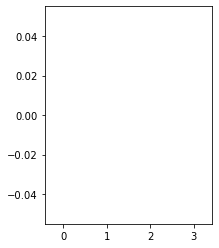

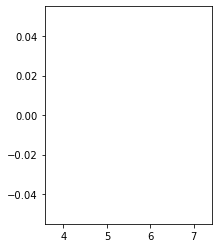

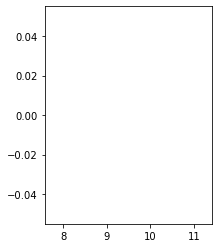

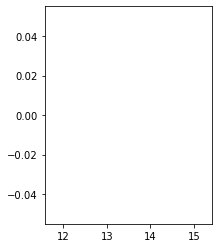

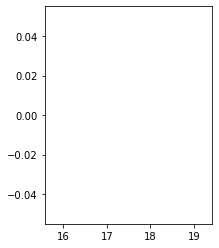

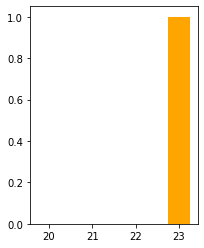

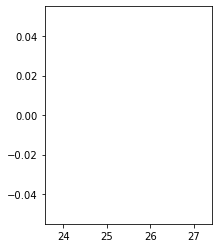

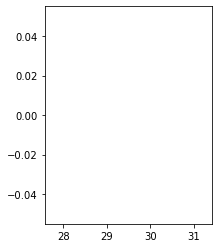

In [49]:
_, Q2_true = get_Q_true(world, idcs)
for s in range(8):
    fig = plt.figure(figsize=(3, 4))
    for a in range(4):
        if a in get_optimal_move(s, Q2_true):
            plt.bar(s*4+a, replays[s*4+a], facecolor='orange', align='center', width=0.5)
        else:
            plt.bar(s*4+a, replays[s*4+a], facecolor='b', align='center', width=0.5)
    plt.savefig(os.path.join(root_folder, 'Paper/Figures_data/%s/Replays/capture_%u_%u.svg'%(fig_name, sub, s)), transparent=True, format='svg')
np.save(os.path.join(root_folder, 'Paper/Figures_data/%s/Replays/replays_data.npy'%fig_name), replays)

### Objective policy change due to those replays

In [50]:
root_folder

'/Users/GA/Documents/Dayan_lab/Optimism_And_Pessimism_In_Optimised_Replay'

State 0, opt: 0.000
State 1, opt: 0.000
State 2, opt: 0.000
State 3, opt: 0.000
State 4, opt: 0.000
State 5, opt: 0.017
State 6, opt: 0.000
State 7, opt: 0.000


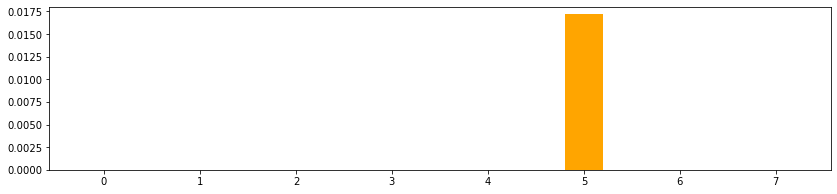

In [52]:
if num_moves == 2:
    Q = z['Q2_history']
else:
    Q = z['Q_history']
Q_before = Q[0].reshape(8, -1)
Q_after  = Q[-1].reshape(8, -1)

_, Q2_true = get_Q_true(world, idcs)

beta = p[0]
a    = p[10]
b    = p[11]
d    = -(a+b)
biases = np.array([a, b, 0, d])

opt_save = []
fig = plt.figure(figsize=(14, 3))
for s in range(8):
    opt = policy_improve(Q_before[s, :], Q_after[s, :], Q2_true, s, beta, biases, world, idcs, mode='value', benefit='subjective')
    print('State %u, opt: %.3f'%(s, opt))
    plt.bar(s, opt, facecolor='orange', width = 0.4)
    opt_save += [opt]
plt.savefig(os.path.join(root_folder, 'Paper/Figures_data/%s/Policy/'%fig_name, 'capture_%u_policy_subjective.svg'%sub), transparent=True, format='svg')
np.save(os.path.join(root_folder, 'Paper/Figures_data/%s/Policy/policy_data_subjective.npy'%fig_name), opt_save)


### Action entropy values 

0 0 alpha: 0.0
0 1 alpha: 0
0 2 alpha: 0.0
0 3 alpha: 0.0
1 0 alpha: 0.0
1 1 alpha: 0.0
1 2 alpha: 0.0
1 3 alpha: 0.0
2 0 alpha: 0.0
2 1 alpha: 0.0
2 2 alpha: 0.0
2 3 alpha: 0.0
3 0 alpha: 0.0
3 1 alpha: 0.0
3 2 alpha: 0
3 3 alpha: 0.0
4 0 alpha: 0.0
4 1 alpha: 0.0
4 2 alpha: 0.0
4 3 alpha: 0.0
5 0 alpha: 4.0
5 1 alpha: 0.0
5 2 alpha: 0.0
5 3 alpha: 0.0
6 0 alpha: 0.0
6 1 alpha: 0.0
6 2 alpha: 0.0
6 3 alpha: 0.0
7 0 alpha: 0.0
7 1 alpha: 0.0
7 2 alpha: 0.0
7 3 alpha: 0.0


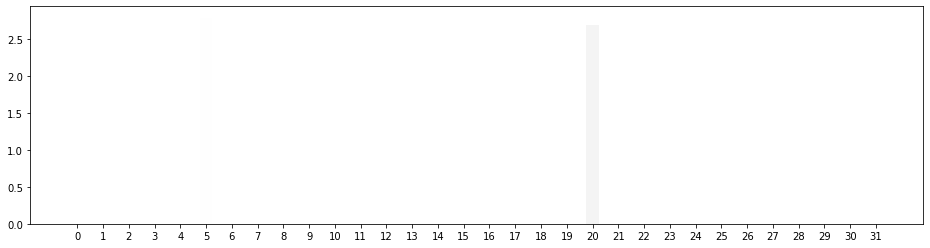

In [53]:
fig = plt.figure(figsize=(16, 4))
max_ent = np.log2(7)

T = z['T']
for s in range(8):
    for a in range(4):
        ent = get_entropy(T, s, a)
        alp = 1-(ent/max_ent)
        if alp < 0:
            alp = 0
        plt.bar(s*4+a, ent, facecolor='k', width=0.5, alpha = alp)
        print(s, a, 'alpha:', np.round(alp*100))
plt.savefig(os.path.join(root_folder, 'Paper/Figures_data/%s/Entropy'%fig_name, 'capture_%u_entropy.svg'%sub), transparent=True, format='svg')
np.save(os.path.join(root_folder, 'Paper/Figures_data/%s/Entropy/entropy_data.npy'%fig_name), opt_save)
plt.xticks(range(32), range(32));

### Agent's state of knowledge

In [54]:
_, Q2_true = get_Q_true(world, idcs)

move  = z['move']
alpha = p[3]
T     = z['T']
tau   = p[9]

if num_moves == 2:
    Q        = z['Q2_history'][0].reshape(8, 4)
    rew_hist = z['rew_history'][1]
    s = int(move[1][0])
    a = int(move[1][1])
    r = move[1][2]
    
    av_rew   = np.mean(rew_hist)

    Q_pre    = (Q  - av_rew*(1-tau))/tau

    Q_before = (Q_pre[s, a] - alpha*r)/(1-alpha)

else:
    Q        = z['Q_history'][0].reshape(8, 4)
    rew_hist = z['rew_history']
    s = int(move[0])
    a = int(move[1])
    r = move[2]
    
    Q_pre    = Q.copy()
    Q_before = (Q_pre[s, a] - alpha*r)/(1-alpha)

State 5, action 0
Before on-line: 2.681007203304325
After on-line: 1.16446515562163


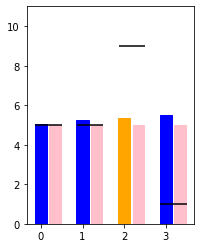

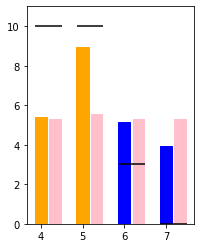

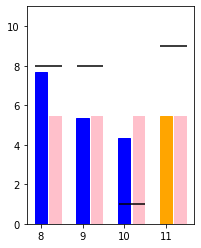

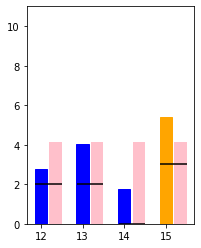

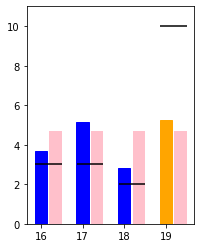

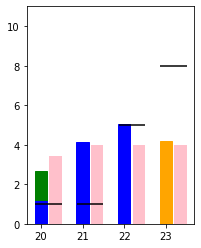

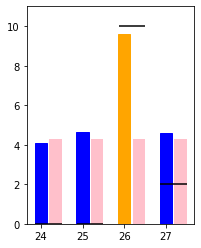

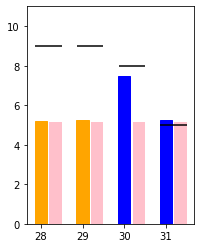

In [55]:
for si in range(8):
    fig = plt.figure(figsize=(3, 4))
    a_opt = get_optimal_move(si, Q2_true)
    q_mb = []
    for ai in range(4):
        this_action_probas = T[si, ai, :]
        r = np.sum(world.ravel()*this_action_probas)
        q_mb += [r]
        if ai in a_opt:
            plt.bar(si*4+ai, Q_pre[si, ai], facecolor='orange', edgecolor='orange', align='center',width=0.3)
            plt.bar(si*4+ai+0.35, r, facecolor='pink', width=0.3)
        else:
            if si == s and ai == a:
#             if s == int(move[0]) and a == int(move[1]):
                plt.bar(si*4+ai, Q_before, facecolor='green', edgecolor='green', align='center',width=0.3)
                print('State %u, action %u'%(s, a))
                print('Before on-line:', Q_before)
                print('After on-line:', Q_pre[si, ai])
            plt.bar(si*4+ai, Q_pre[si, ai], facecolor='b', edgecolor='b', align='center',width=0.3)
            plt.bar(si*4+ai+0.35, r, facecolor='pink', width=0.3)
        plt.hlines(Q2_true[si, ai], si*4+ai-0.13, si*4+ai+0.5)
    plt.ylim(0, 11)
    plt.savefig(os.path.join(root_folder, 'Paper/Figures_data/%s/Q'%fig_name, 'Q_before_%u.svg'%si), transparent=True, format='svg')
    if si != s:
        np.savez(os.path.join(root_folder, 'Paper/Figures_data/%s/Q'%fig_name, 'Q_%u.npz'%si), q_mf=Q_pre[si, :], q_mb=q_mb)
    else:
        np.savez(os.path.join(root_folder, 'Paper/Figures_data/%s/Q'%fig_name, 'Q_%u.npz'%si), q_mf=Q_pre[si, :], q_mf_before=Q_before, q_mb=q_mb)
